# Modal analysis of a free vibrating propeller

In this notebook we analyze a vibrating propeller on which there are no boundary conditions applied, physically this means we look at a free vibrating propeller.

We will impport dolfin, mshr and the python packages numpy and pyplot.

In [127]:
from dolfin import *
from mshr import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

There are no forces applied since there are no Dirichlet boundary conditions applied (so the model is not "attached" to anything and will fly away once a force is applied). The material properties are those of steel.

In [128]:
# Elasticity parameters
E, nu = 210e9, 0.3
mu, lmbda = Constant(E/(2*(1 + nu))), Constant(E*nu/((1 + nu)*(1 - 2*nu)))

# Mass density and viscous damping coefficient
rho, eta = 7.8e4, 0.0

# applied force
force = -1e5
grav = -9.81

Creating a mesh and its boundaries:

In [210]:
# Set parameters
r = 0.125
R = 0.5
w = 0.3
h = 0.025
rotate_blades = False
include_tip = False
extra_rotation = False # only applied to inner mesh
resolution = 40

# Define geometries
sphere = Sphere(Point(0, 0, 0), 2*R)
geometry_inside = CSGGeometries.propeller(r, R, w, h, rotate_blades, include_tip)
geometry_outside = sphere - geometry_inside

# Generate meshes
mesh = generate_mesh(geometry_inside, resolution)
#mesh_outside = generate_mesh(geometry_outside, resolution)
#mesh = UnitCubeMesh(20,20,20)
# Report size of meshes
print("Mesh of propeller inside:  %d cells" % mesh.num_cells())
#print("Mesh of propeller outside: %d cells" % mesh_outside.num_cells())

# Save meshes to file
File("propeller_free/propeller_inside.pvd") << mesh
#File("propeller_free/propeller_outside.pvd") << mesh_outside



Mesh of propeller inside:  22555 cells


In [211]:
class ShaftConnection(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and x[2]>0. and x[0]**2 + x[1]**2 <= r**2 + DOLFIN_EPS_LARGE
    
    
shaft = ShaftConnection()

Defining loads and taking inertia into account for the governing balance equation

There are a number of functions defined on the vectorspace $\mathcal{V}$: the displacement, velocity and acceleration. 

The beam is clamped on the left, therefore Dirichlet boundary conditions are applied to set the displacement to zero there.

The material is modeled as homogenous and isotropic so the stress tensor is given simply by:
$$
\boldsymbol{\sigma} = \mu\boldsymbol{\epsilon} + \lambda \text{tr}(\boldsymbol{\epsilon})\mathbf{I}
$$

In [212]:
# Create function space
V = VectorFunctionSpace(mesh, "Lagrange", 1)

# Create test and trial functions, and source term
u1, w = TrialFunction(V), TestFunction(V)
v1 = TestFunction(V)

# Fields from previous step
u0, v0, a0 = Function(V), Function(V), Function(V)

# Define loads
bb = Constant((0., 0., grav))
tt = Constant((0.0, 0.0, force))

# Define boundary conditions
#bc = DirichletBC(V, Constant((0.0, 0.0, 0.0)), shaft)

# Stress function
#def sigma(u, v):
#    return 2.0*mu*sym(grad(u)) + (lmbda*tr(grad(u)) + eta*tr(grad(v)))*Identity(len(u))

def sigma(u):
    return 2.0*mu*sym(grad(u)) + lmbda*tr(grad(u))*Identity(len(u))


Using PETSc-matrices we can set up the stiffness, mass and force vectors of the domain by using the stiffness of the beam given by inner product of the stress and deformation: $<\sigma, \epsilon>$. The mass is calculated using the density and the force is defined by the body force (gravity) and a load applied on the beam edge to the right, which is given.

In [213]:
# Set up stiffness matrix
A_k = PETScMatrix()
#assemble(inner(sigma(u1, v1), sym(grad(w)))*dx, A_k)
assemble(inner(sigma(u1), sym(grad(w)))*dx, A_k)
# Set up mass matrix
A_m = PETScMatrix()
assemble(rho*dot(u1, w)*dx, A_m)
# Set up force vector
F_s = PETScVector()
assemble(dot(bb, w)*dx, F_s) 

# If there are boundary conditions apply them here:
#bc.apply(A_k)
#bc.zero(A_m)
#bc.apply(F_s)

<dolfin.cpp.la.PETScVector; proxy of <Swig Object of type 'std::shared_ptr< dolfin::PETScVector > *' at 0x7f706cf78300> >

Based on the stiffness and mass matrices, compute the modes and project the system on a modal basis so that:
$$
\phi^t\mathbf{K}\phi = \mathbf{K}_m \\
\phi^t\mathbf{M}\phi = \mathbf{M}_m \\
\phi^t\mathbf{f} = \mathbf{f}_m
$$

In [214]:
solver = SLEPcEigenSolver(A_k, A_m)

# Number of modes to take into account
neigs = 10

solver.parameters["spectrum"] = "smallest real"
solver.parameters["spectral_transform"] = "shift-and-invert"
solver.parameters["spectral_shift"] = 10.
solver.solve(neigs)

# Extract and plot modes
modes=[]
eigvalues=[]
vtkfile = File('propeller_free/modes.pvd')  
for md in range(neigs):
    r, c, rx, cx = solver.get_eigenpair(md)
    # Initialize function and assign eigenvector
    #if not (r > 1.-1.e-8 and r < 1.+1.e-8):    # filter out spurious eigenvectors
    mode = Function(V)
    mode.rename("mode",'mode')
    mode.vector()[:] = rx
    modes.append(mode)
    eigvalues.append(r + 1j* c)
    # Save mode to file
    vtkfile << (mode, r)    
    del(mode)


In [215]:
nmodes = len(eigvalues)
l_vec = len(modes[0].vector().array())

mode_array = np.zeros((l_vec, nmodes))
for i in range(nmodes):
    mode_array[:, i] = modes[i].vector().array()  
start_mode = 3
mode_array = mode_array[:, start_mode:]

F_modal = np.dot(mode_array.T, F_s.array()[:])
K_modal = np.dot(np.dot(mode_array.T, A_k.array()[:]), mode_array)
M_modal = np.dot(np.dot(mode_array.T, A_m.array()[:]), mode_array)

In [216]:
# Look at the first natural frequency and period
freq = (np.array(eigvalues[start_mode])**0.5).real

# The modal frequencies are related to natural periods by T = 2*pi/f
period0 = 2*np.pi / freq
print(period0)

1.30281681017


Now that we have computed the discretised equations of motion projected on the modal basis, we can start to look at the dynamics. For the dynamic problem we will not concentrate on the modal time-function but use a direct time-integration to show what happens with the modes over time.

### Extra matrix analysis ###
In the following lines of code we will show some effects that occur when analyzing the modal matrices a bit more. 

The modal mass and stiffness matrices are not diagonal at all (a mess), so if the difference between the eigenvalues and the diagonal of the normalized modal stiffness matrix.

This means that the method is probably not working. 

Maybe the eigenvalue solver needs to improve? 

Maybe the problem is ill-defined and we actually need boundary conditions?

Not sure what the problem is but it needs some more investigation.

In [217]:
# For some reason the K_modal matrix does not contain the eigenvalues on the diagonal
# The relative difference between the eigenvalues and the matrix diagonals is still small though
print(np.linalg.norm((K_modal / M_modal).diagonal() - eigvalues[start_mode:]) / np.linalg.norm(eigvalues[start_mode:]))

0.299247749305


In [218]:
(K_modal / M_modal).diagonal()

array([ -1.21338873e+02,  -1.15983246e+03,   1.01665235e+04,
        -8.01751650e+04,  -2.12150677e+04,   1.20385179e+05,
         7.24155871e+05])

In [219]:
eigvalues[start_mode:]

[(23.259106619903736+0j),
 (395.66029228868126+0j),
 (16114.76041519535+0j),
 (96989.70079355843+0j),
 (118930.35979562227+0j),
 (123386.69260598635+0j),
 (729105.1474150247+0j)]

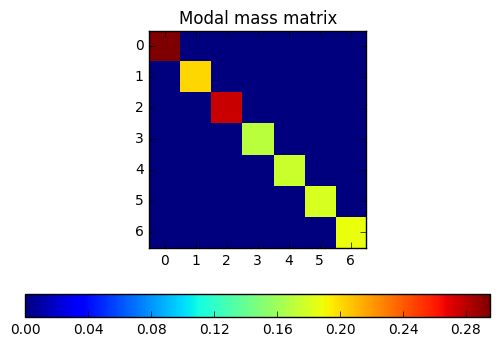

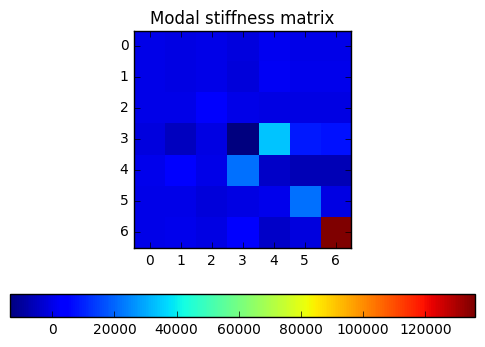

In [220]:
plt.figure()
plt.title("Modal mass matrix")
ax = plt.imshow(M_modal, interpolation='nearest')
cbar = plt.colorbar(ax, orientation='horizontal')
plt.show()

plt.figure()
plt.title("Modal stiffness matrix")
ax = plt.imshow(K_modal, interpolation='nearest')
cbar = plt.colorbar(ax, orientation='horizontal')
plt.show()

In [221]:
# Look at natural frequencies and natural periods
freqs = (np.array(eigvalues)**0.5).real
# the first two eigenvalues seem to be due to boundary conditions
print(eigvalues)
# The modal frequencies are related to natural periods by T = 2*pi/f
#periods = 2*np.pi / freqs
#print(periods)

[(-88491.32095364499+0j), (-18927.707619300727+0j), (-0.8155019655353417+0j), (23.259106619903736+0j), (395.66029228868126+0j), (16114.76041519535+0j), (96989.70079355843+0j), (118930.35979562227+0j), (123386.69260598635+0j), (729105.1474150247+0j)]


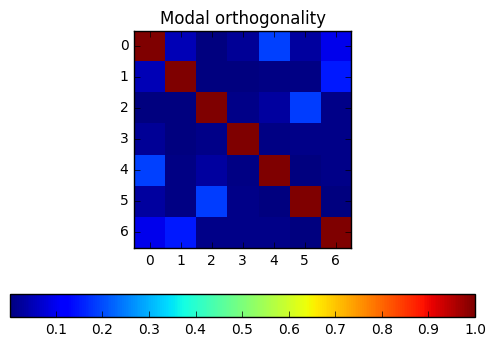

In [222]:
Influence_matrix = np.dot(mode_array.T, mode_array)
plt.figure()
plt.title("Modal orthogonality")
ax = plt.imshow(abs(Influence_matrix), interpolation='nearest')
cbar = plt.colorbar(ax, orientation='horizontal')
plt.show()

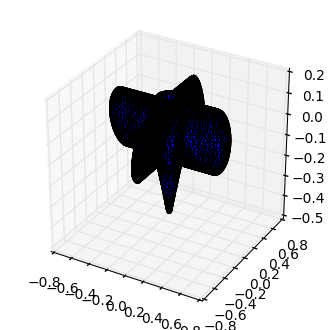

In [14]:
plot(mesh)